# XLNet for Tweet Sentiment Extraction



## Overview

### Context
Kaggle's 2020 [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) competition provided me with an opportunity to test out recently developed state-of-the-art machine learning models whose performance on some natural language processing (NLP) tasks have exceeded that of humans. 

I focused on the Google AI Brain Team's XLNet model. Two variations on this XLNet model were ensembled with a RoBERTa model fine-tuned by my Kaggle teammate to win us a silver medal (top 5%). This notebook shows the preprocessing of the data, training of the model and use of the trained model to make predictions.

## Competition Objective

The  competition dataset contained over 27,000 tweets that had each been labelled with their "sentiment". For example, a tweet like "*I just spent the day with a labradoodle called Sporky. He is amazing.*" would likely be labelled with the sentiment positive.

The objective of the competition was not to reproduce this sentiment labelling, but to determine the word or phrase within the tweet that had led it to be labelled as having a positive, negative or neutral sentiment. For example, in our tweet "*I just spent the day with a labradoodle called Sporky. He is amazing.*", the phrase "*He is amazing*" could arguably be the phrase that led it to be labelled positive.

### What is XLNet?
The current state-of-the-art NLP models combine several new and existing ideas, including:
* Learning **word embeddings**, or representations of words that exist in a semantic space where distance between words indicates the relationship between them (see Word2Vec and GloVe). For example, the relative positions of the word embeddings of "son" and "mother" in semantic space, would be similar to the relative positions of "Prince" and "Queen".
* Paying **attention** to the context of a word to help the model learn its meaning (see ELMo). For example, in the sentences "The stick fell from the tree." and "I should stick to my day job", the surrounding words help us understand that the word "stick" has different meanings in each.
* Neural network architectures known as Transformers that allow for **parallelisation** thereby speeding training and inference, and new attention mechanisms that can understand **long-range dependencies** between words better than previous RNN-based architectures.
* Training models using **transfer learning** methods (see ULMFit), where the model is first pretrained on a general language task with a massive unlabelled dataset. For example, the model might be trained to predict the missing word in a sentence taken from the corpus of all English Wikipedia entries. Once the model has been trained on this task, it is then fine-tuned on a different task with a  task-specific dataset that is usually much smaller. 

Like several other new NLP models, XLNet is based on a variation on the Transformer architecture and has been pretrained on a large-scale unlabeled text corpus, and is then made available for fine-tuning on user-specific tasks.

One difference between XLNet and its predecessors is in the language task that it uses during pretraining. XLNet uses permutation sampling rather than masking of the input sequences in an attempt to take into account potential dependencies between the words that it is trying to predict. For example, given the task to fill in the blanks in the sentence "_ _ is the greatest city in the world.", previous models like BERT might make odd predictions like "New Francisco" or "San York", while XLNet, because it is not taking into account the semantic dependencies between the missing words, would be more likely to predict "New York" or "San Francisco".

#### Pipeline Overview

XLNet comes pre-trained by Google on an enormous corpus of text drawn from sources like books and English Wikipedia. It is up to the user to fine-tune the model on their specific language task. In our case we have a "question answering" task. That is, given a question (in our case, the sentiment label) and a passage of text containing the answer (the tweet), XLNet needs to highlight the “span” of text corresponding to the correct answer (the word or phrase that gave rise to the sentiment labelling). 

##### **Preprocessing**
To give the pre-trained model a greater chance of understanding the text contained in a tweet, I implemented a preprocessing pipeline that cleaned the tweets, removing or transforming features like:
* slang e.g. 'LOL' -> 'laugh out loud'
* emojis e.g. ':)' -> 'happy'
* misspellings e.g. 'verrrrrrry' -> 'very'
* html character references e.g. '\&amp;' to '&'
    
##### **Training**
The model was then trained with the preprocessed dataset using 
* Early stopping and cross-validation
* AdamW weight decay and a learning rate that linearly increases during a warmup period and subsequently decreases linearly to zero.

with a stack including
* HuggingFace's Transformers library which provides a variety of models pretrained for language tasks
* PyTorch, a framework for GPU-based training of deep neural networks
* GPU time for model fine-tuning provided by Google Colab.

##### **Prediction** 
The trained model was then used to predict out of sample data provided by Kaggle and saved for subsequent inclusion in the ensemble model. 

##### **Next Steps**

Given that a single fine-tuning of the XLNet model typically consumed more than a full day, I was somewhat constrained in the space of experimentation with the model. But with additional resources I would have focused on:
* Obtaining unbiased estimates of out of sample loss
* Optimisation of hyperparameters

### Sources
The following were useful resources for understanding aspects of the architecture or provided code snippets and hints.
* [Visualisation of the attention mechanism in RNNs used for translation](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) 
* [Illustration of the transformer architecture](https://jalammar.github.io/illustrated-transformer/) and [an annotated version of the original paper on using attention with transformers](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
* [Illustration of the BERT architecture](http://jalammar.github.io/illustrated-bert/)
* The original [XLNet paper](https://arxiv.org/abs/1906.08237), and a useful [slide deck on XLNet](https://www.cs.princeton.edu/courses/archive/spring20/cos598C/lectures/lec5-pretraining2.pdf)
* [Useful video explaining the use of tokenisers](https://www.youtube.com/watch?v=U51ranzJBpY)
* Useful notebooks illustrating how to [train BERT](https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch) and [run inference with RoBERTa](https://www.kaggle.com/abhishek/roberta-inference-5-folds)
* Snippets for [checking where a notebook is running](https://www.kaggle.com/masterscrat/detect-if-notebook-is-running-interactively) and [Kaggle submission](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/141502).

## Setup

### Installations and imports

In [64]:
!pip install transformers
!pip install tokenizers
!pip install protobuf
!pip install sentencepiece

In [65]:
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    !wget https://raw.githubusercontent.com/google/sentencepiece/master/python/src/sentencepiece/sentencepiece_pb2.py
    !wget https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model
except:
    IN_COLAB = False
    
    import sys
    sys.path.append('/kaggle/input/sentencepiece-pb2/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2021-04-06 11:31:52--  https://raw.githubusercontent.com/google/sentencepiece/master/python/src/sentencepiece/sentencepiece_pb2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8128 (7.9K) [text/plain]
Saving to: ‘sentencepiece_pb2.py.1’

sentencepiece_pb2.p 100%[===================>]   7.94K  --.-KB/s    in 0s      

2021-04-06 11:31:52 (93.3 MB/s) - ‘sentencepiece_pb2.py.1’ saved [8128/8128]

--2021-04-06 11:31:52--  https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.46|:443.

In [85]:
import os
import string
import re
import html
import random
import gc
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
import tokenizers
import torch
import torch.nn as nn
from torch.nn import functional as F
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import sentencepiece as spm
import sentencepiece_pb2

In [154]:
tqdm = partial(tqdm, position=0, leave=True)
fontsize=14

### Configure device, paths, tokenizer

In [68]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [69]:
class SentencePieceTokenizer:
    def __init__(self, model_name):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_name)
    
    def encode(self, sentence):
        spt = sentencepiece_pb2.SentencePieceText()
        spt.ParseFromString(self.sp.encode_as_serialized_proto(sentence))
        offsets = []
        ids = []
        for piece in spt.pieces:
            ids.append(piece.id)
            offsets.append((piece.begin, piece.end))
        return {'ids' : ids,
                'offsets' : offsets}
                

class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 16 # 32 #64
    VALID_BATCH_SIZE =  16
    EPOCHS = 10
    
    MODEL_CONFIG = transformers.XLNetConfig
    MODEL = transformers.XLNetForQuestionAnswering
    if IN_COLAB:
        BASE_PATH = Path.cwd() / "drive" / "My Drive" / "kaggle" / "tweet_sentiment_extraction"     
        MODEL_PATH = BASE_PATH  / "model_save" / "model_0613_6"
        FOLDED_TRAINING_FILE = BASE_PATH / "input" / "train-5fold" / "train_folds.csv"
        TRAINING_FILE = BASE_PATH / "input" / "train.csv"
        TESTING_FILE = BASE_PATH  / "input" / "test.csv"
        SAMPLE_SUBMISSION_FILE = BASE_PATH / "input" / "sample_submission.csv"
        SUBMISSION_FILE = BASE_PATH / "input" / "submission.csv"
        SLANG_FILE = BASE_PATH / "input" / "slang_abbreviations.csv"
        EMOJIS_FILE = BASE_PATH / "input" / "emojis.csv"
        PRIVATE_TEST = BASE_PATH / "input" / "test_private_df.csv"
    else:
        BASE_PATH = Path('/kaggle')
        MODEL_PATH = BASE_PATH  / "input" / "xlnetmodel06136"
        FOLDED_TRAINING_FILE = BASE_PATH / "working" / "train_folds.csv"
        TRAINING_FILE = BASE_PATH  / "input" / "tweet-sentiment-extraction" / "train.csv"
        TESTING_FILE = BASE_PATH  / "input" / "tweet-sentiment-extraction" / "test.csv"
        SAMPLE_SUBMISSION_FILE = BASE_PATH / "input" / "tweet-sentiment-extraction" / "sample_submission.csv"
        SUBMISSION_FILE = BASE_PATH / "working" / "submission.csv"
        SLANG_FILE = BASE_PATH / "input" / "slang-abbreviations" / "slang_abbreviations.csv"
        EMOJIS_FILE = BASE_PATH / "input" / "slang-abbreviations" / "emojis.csv"
    
    PRETRAINED_MODEL_DIR = BASE_PATH / "input" / "xlnetbasecased"
    TOKENIZER = SentencePieceTokenizer(str(PRETRAINED_MODEL_DIR / 'xlnet-base-cased-spiece.model'))
    SLANG_DICT = (pd.read_csv(SLANG_FILE,
                              header=None,
                              names=['slang', 'normalised'])
                    .set_index('slang')
                    .to_dict()['normalised'])
    EMOJI_DICT = (pd.read_csv(EMOJIS_FILE, 
                              header=None, 
                              names=['emoji', 'normalised'])
                    .set_index('emoji')
                    .to_dict()['normalised'])

## Tweet Preprocessing

For efficient training with PyTorch on the GPU, we create a custom DataSet class that will be used to deliver the data to the model in batches. 
This dataset will apply the preprocessing defined below when an individual tweet is selected from the batch.


In [11]:
def update_clean_to_raw_map(map_clean_to_raw: list,
                            text: str,
                            index_raw: int) -> list:
    """
    For each word in the cleaned text, append its corresponding position in the 
    raw tweet to the mapping vector.
    """
    num_words = len(text.split())
    map_clean_to_raw += [index_raw]*num_words

    return map_clean_to_raw

def remove_odd_chars(text: str) -> str:
    """Removes some special characters that appear in the dataset"""
    cleaned_text = re.sub('&not', ' not', text)
    cleaned_text = re.sub('Â', 'A', cleaned_text) #¡
    cleaned_text = re.sub(r'(ï¿½)', "'", cleaned_text)
    cleaned_text = re.sub(re.escape('^'), ".", cleaned_text)

    return cleaned_text

def replace_character_reps(text: str) -> str:
    """
    Reduce any sequences of more than two repetitions of a character to 
    one character. For example,  sorryyyyyy -> sorry, sleeeeeeep -> slep
    The sequence 'wwww.' will not be modified.
    """
    cleaned_text = re.sub(r'(?!www.)([a-zA-Z\!])\1{2,}', '\\1',
                        text,
                        flags=re.I)
    return cleaned_text

def replace_urls(text: str) -> str:
    """"
    Replace any urls in the text with the string 'URL'
    """
    cleaned_text = re.sub(r'((http://|https://|www.)[^\s-]*)',
                        'URL',
                        text)
    return cleaned_text

def replace_emojis(text: str, emoji_dict: dict = config.EMOJI_DICT) -> str:
    """"
    Replace any words in the text that are found in the emoji dictionary with 
    their non-slang meaning
    https://en.wikipedia.org/wiki/List_of_emoticons
    """
    cleaned_text = ' '.join([emoji_dict[w] 
                            if w in emoji_dict.keys() 
                            else w 
                            for w in text.split()])
    return cleaned_text

def replace_slang(text: str, slang_dict: dict = config.SLANG_DICT) -> str:
    """"
    Replace any words in the text that are found in the slang dictionary with 
    their non-slang meaning
    # # https://www.webopedia.com/quick_ref/textmessageabbreviations.asp
    """
    cleaned_text = ' '.join([slang_dict[w] 
                            if w in slang_dict.keys() 
                            else w 
                            for w in text.split()])
    return cleaned_text

def replace_html(text: str) -> str:
    """Replace html references with unicode"""
    return html.unescape(text)

def clean_word(word: str, slang_dict: dict = config.SLANG_DICT, 
               emoji_dict: dict = config.EMOJI_DICT) -> str:
    """
    Apply multiple cleaning operations to a single word.
    The cleaned word may contain multiple words
    """
    text = replace_html(word)
    text = replace_slang(text, slang_dict)
    text = replace_emojis(text, emoji_dict)
    text = replace_urls(text)
    text = replace_character_reps(text)

    return text

def clean_text(raw_text: str, 
               slang_dict: dict = config.SLANG_DICT, 
               emoji_dict: dict = config.EMOJI_DICT) -> {str, list}:
    """
    Apply cleaning to each word within a piece of text.
    Substitute html references, replace slang, emojis, and sequences of repeated 
    letters. Note, this cleaning misses emojis or slang that don't take up the
    whole word (e.g. LOL!, &amp:this).
    Finally, some special characters are removed/modified.

    This cleaning can change the number of words in the text, so a  
    vector is returned that maps from words in the cleaned text to the 
    original text.

    Returns a dictionary containing
    - cleaned_text: str representing the cleaned text 
    - map_clean_to_raw: list representing the  mapping vector from words in 
    the cleaned text to corresponding words in the original text
    """

    cleaned_text = []
    map_clean_to_raw = []

    for index_raw, word in enumerate(raw_text.split()):
        # output string may contain multiple words
        cleaned_word = clean_word(word, slang_dict, emoji_dict) 

        map_clean_to_raw = update_clean_to_raw_map(map_clean_to_raw,
                                                    cleaned_word,
                                                    index_raw)
        cleaned_text.append(cleaned_word)     

    cleaned_text = ' '.join(cleaned_text)
    cleaned_text = remove_odd_chars(cleaned_text)

    return cleaned_text, map_clean_to_raw

def clean_selected_text(selected_text: str, full_tweet: str,
                        slang_dict: dict = config.SLANG_DICT, 
                        emoji_dict: dict = config.EMOJI_DICT) -> str:
    """
    To ensure that the cleaned selected_text is a substring of the cleaned
    tweet, we modify the selected_text so that its first and last words are 
    complete words in the (uncleaned) full_tweet. 
    For example, if we have:
    * full_text = 'This is ridiculoussss'
    * selected_text = 'is ridiculous'
    We change the selected text to 'is ridiculoussss'

    We then clean the selected_text in the same way we clean the full tweet.

    Returns the cleaned tweet.
    """
    try:
        cleaned_selected_text = re.search('\S*'+re.escape(selected_text)+'\S*', 
                                      full_tweet).group()
    except:
        print(full_tweet)
        print(selected_text)
        raise()

    cleaned_selected_text, _ = clean_text(cleaned_selected_text, )

    return cleaned_selected_text
    
def find_selected_text_token_indices(offsets: list,
                                     selected_text: str,
                                     tweet: str) -> (int, int):
    """
    Arguments
    * offsets: list of "span", pairs of integers representing slice indices 
    associated with each token generated from the tweet. For example, if the
    first element of offsets is (0, 1), the first token represents the slice
    tweet[0:1], a single letter.
    * selected_text: a substring of tweet
    * tweet: string

    Returns
    * target_start the index in offsets of the span containing the first
     character of selected_text.
    * target_end the index in offsets of the span containing the last
     character of selected_text.
    """

    selected_text_span = re.search('\S*'+re.escape(selected_text)+'\S*',
                                   tweet).span()

    target_start = None
    target_end = None
    for j, o in enumerate(offsets):
        if target_start is None and o[1]>selected_text_span[0]:
            target_start = j
        if target_end is None and o[1]>=selected_text_span[1]:
            target_end = j
            break
    if target_end is None: target_end = len(offsets)-1

    if target_end is None or target_start is None:
        print(tweet)
        print(selected_text)
        print('target_start: '+str(target_start))
        print('target_end: '+str(target_end))
        print('selected text span: '+str(selected_text_span))
        print(offsets)
        raise

    return target_start, target_end
    
def format_tweet(tweet, selected_text, sentiment, tokenizer, max_len,
                 slang_dict, emoji_dict):
    """
    Preprocessing the data to the XLNet model formatting
    """

    cleaned_tweet, map_clean_to_raw = clean_text(tweet, slang_dict, emoji_dict)
    cleaned_selected_text = clean_selected_text(selected_text, tweet,
                                                slang_dict, emoji_dict)

    tknzd = tokenizer.encode(cleaned_tweet)
    ids = tknzd['ids']
    offsets = tknzd['offsets']

    target_start, target_end = find_selected_text_token_indices(offsets,
                                                                cleaned_selected_text,
                                                                cleaned_tweet)

    sentiment_id = {
        'positive': 19036,
        'negative': 25976,
        'neutral': 24734
    }
    
    # https://huggingface.co/transformers/model_doc/xlnet.html#transformers.XLNetTokenizer.build_inputs_with_special_tokens
    token_type_ids = [0]*2 + [1] * (len(ids)+1) + [2]
    ids = [sentiment_id[sentiment]] + [4] + ids + [4] + [3]
    #ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + ids + [2]
    mask = [1] * len(token_type_ids)
    offsets = [(0, 0)] * 2 + offsets + [(0, 0)] * 2
    target_start += 2
    target_end += 2

    padding_length = max_len - len(ids)
    if padding_length > 0:
        ids = ids + ([5] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)
    map_clean_to_raw += [0]*(max_len - len(map_clean_to_raw))
    
    return {
        'token_type_ids': token_type_ids,
        'ids': ids,
        'mask': mask,
        'target_start': target_start,
        'target_end': target_end,
        'sentiment': sentiment,
        'offsets': offsets,
        'cleaned_tweet': cleaned_tweet,
        'cleaned_selected_text': cleaned_selected_text,
        'raw_tweet': tweet,
        'raw_selected_text': selected_text,
        'map_clean_to_raw': map_clean_to_raw
    }

class TweetDataset:
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
        self.slang_dict = config.SLANG_DICT
        self.emoji_dict = config.EMOJI_DICT
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        data = format_tweet(
            self.tweet[item], 
            self.selected_text[item], 
            self.sentiment[item],
            self.tokenizer,
            self.max_len,
            self.slang_dict,
            self.emoji_dict
            )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'target_start': torch.tensor(data["target_start"], dtype=torch.long),
            'target_end': torch.tensor(data["target_end"], dtype=torch.long),
            'offsets': torch.tensor(data["offsets"], dtype=torch.long),
            'sentiment': data["sentiment"],
            'raw_tweet': data["raw_tweet"],
            'raw_selected_text': data["raw_selected_text"],
            'cleaned_tweet': data['cleaned_tweet'],
            'cleaned_selected_text': data['cleaned_selected_text'],
            'map_clean_to_raw': torch.tensor(data['map_clean_to_raw'], dtype=torch.long)# '_'.join([str(x) for x in data['map_clean_to_raw']])
        }

## Training

### Model Architecture

Here we take a quick look at the model architecture of the pre-trained model provided by Hugging Faces's transformers library.

In [14]:
def init_model(config):
    model_config = config.MODEL_CONFIG.from_pretrained(config.PRETRAINED_MODEL_DIR )#/ "config.json")
    model_config.output_hidden_states = True
    model_config.start_n_top = config.MAX_LEN
    model_config.end_n_top = config.MAX_LEN
    #'/kaggle/input/xlnet-base-tf/xlnet-base-cased'
    model = config.MODEL.from_pretrained(config.PRETRAINED_MODEL_DIR,
                                         config=model_config)#, state_dict='/kaggle/input/xlnetmodel05081/model_3.bin')
    
    return model

In [80]:
config.MAX_LEN = 1
model = init_model(config)
model = model.to(device)
model.eval()

Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

XLNetForQuestionAnswering(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, 

### Visualise Embeddings

Here we quickly illustrate the concept of relationships between word embeddings mentioned in the Overview with a couple of visualisations.

First we create a list of words, pass each one to the XLNet model and then extract the corresponding word embedding from the model.

In [164]:
words = ['dog', 'cat', 'puppy', 'pet', 'bark', 'tree', 'religion',
             'document', 'priest', 'the', 'a', 'an']
embeddings = []

for w in words:
    tknzd = config.TOKENIZER.encode(w)

    ids = tknzd['ids']
    offsets = tknzd['offsets']

    tensor_ids = torch.LongTensor(ids)
    tensor_ids = tensor_ids.to(device)
    # unsqueeze IDs to get batch size of 1 as added dimension
    tensor_ids = tensor_ids.unsqueeze(0)

    with torch.no_grad():
        out = model(input_ids=tensor_ids)
        embeddings.append(out['hidden_states'][0][0][0].tolist())
        

Each word embedding is a 768 dimensional vector. Next, we visualise them with a heatmap, where each column represents a different word, and each row represents a different dimension.


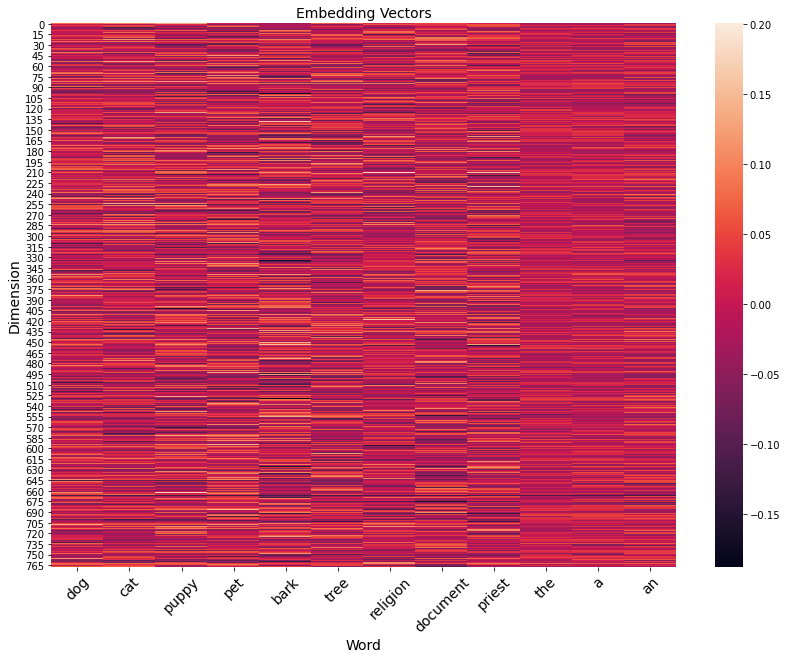

In [162]:
figsize(14, 10) 
sns.heatmap(pd.DataFrame(embeddings).transpose().fillna(0));
plt.xticks(ticks=[x+0.5 for x in list(range(len(words)))],
           labels=words, 
           rotation=45,
           fontsize=fontsize)
plt.ylabel('Dimension', fontsize=fontsize)
plt.xlabel('Word', fontsize=fontsize)
plt.title('Embedding Vectors', fontsize=fontsize);

If we look closely, we could infer that the representations of the article words "the", "a", and "an" look more muted compared to the other verbs and nouns. But it's hard to tell very much more from this visualisation.

Let's try instead visualising the *correlations* between the word embeddings. This should help us see the degree of similarity between pairs of word embeddings.

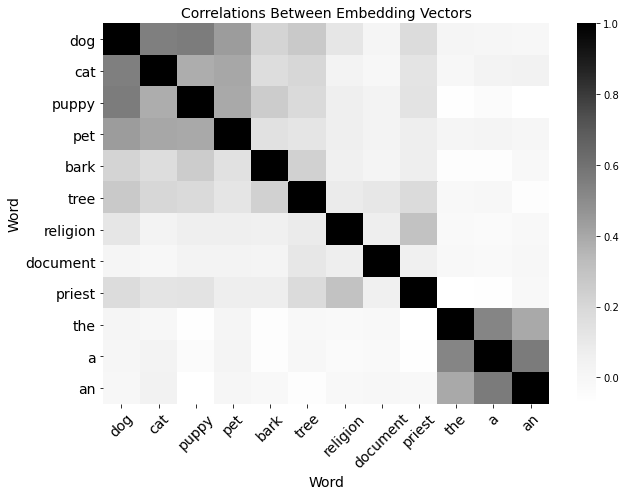

In [163]:
figsize(10, 7)
sns.heatmap(pd.DataFrame(embeddings).transpose().fillna(0).corr(),
            cbar=True,
            cmap='Greys')
plt.xticks(ticks=[x+0.5 for w in list(range(len(words)))],
           labels=sentences, 
           rotation=45,
           fontsize=fontsize)
plt.yticks(ticks=[x+0.5 for w in list(range(len(words)))],
           labels=sentences,
           rotation=0,
           fontsize=fontsize)
plt.ylabel('Word', fontsize=fontsize)
plt.xlabel('Word', fontsize=fontsize)
plt.title('Correlations Between Embedding Vectors', fontsize=fontsize);

Now we have a much clearer picture. We can see, for example, that the representation of "dog" is most similar (darker) to that of "puppy", and then "cat" and "pet". The embedding of "bark" is most similar to that of "puppy" and "tree".
Meanwhile the articles "the", "a" and "an" form their own cluster in the bottom left, separate from the other parts of speech.

### Training functions

In [70]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 24
seed_everything(seed) 

In [12]:
def extract_predicted_text(ids, predicted_start, predicted_end, cleaned_tweet, 
                           raw_tweet, map_clean_to_raw, sentiment):

    # in certain cases, just predict the whole raw tweet
    if sentiment == "neutral" or len(raw_tweet.split()) < 2:
        raw_predicted_text = raw_tweet
        return raw_predicted_text

    if predicted_end < predicted_start:
        predicted_end = predicted_start
    
    predicted_text = config.TOKENIZER.sp.decode_ids(ids[predicted_start:
                                                        predicted_end+1])

    # get the starting and ending word numbers of the predicted text within the 
    # cleaned tweet
    # we first expand the predicted text so that it contains complete words
    predicted_text = re.search('\S*'+re.escape(predicted_text)+'\S*',
                               cleaned_tweet).group()

    predicted_words = predicted_text.split()
    cleaned_tweet_words = cleaned_tweet.split()
    index_start_word, index_end_word = None, None
    for i in range(len(cleaned_tweet_words)):
        if predicted_words == cleaned_tweet_words[i:i+len(predicted_words)]:
            index_start_word = i 
            index_end_word = i + len(predicted_words) - 1
            break

    # map these word numbers into the word numbers of the raw tweet
    # and extract the uncleaned version of the predicted text
    raw_tweet_words = raw_tweet.split()
    raw_predicted_text = raw_tweet_words[map_clean_to_raw[index_start_word]:
                                         map_clean_to_raw[index_end_word]+1]
    raw_predicted_text = ' '.join(raw_predicted_text)                   

    return raw_predicted_text

def get_batch_loss(batch, model, mode='eval'):
    ids = batch["ids"].to(device, dtype=torch.long)
    token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
    mask = batch["mask"].to(device, dtype=torch.long)
    target_start = batch["target_start"].to(device, dtype=torch.long)
    target_end = batch["target_end"].to(device, dtype=torch.long)

    if mode=='train':
        model.zero_grad()

    outputs = model(
        input_ids=ids,
        attention_mask=mask,
        token_type_ids=token_type_ids,
        start_positions=target_start,
        end_positions=target_end
    )
    loss = outputs[0]

    return loss

def get_batch_start_end_positions(batch, model):
    ids = batch["ids"].to(device, dtype=torch.long)
    mask = batch["mask"].to(device, dtype=torch.long)
    token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
    raw_tweet = batch["raw_tweet"]
    raw_selected_text = batch["raw_selected_text"]
    sentiment = batch["sentiment"]

    # run it again to get the probabilities
    # https://huggingface.co/transformers/model_doc/xlnet.html#xlnetforquestionanswering
    outputs = model(
        input_ids=ids,
        attention_mask=mask,
        token_type_ids=token_type_ids
    )
    # start_top_index contains the model.start_n_top highest probability
    # starting sequence positions, in decreasing order of probability
    start_top_probs = outputs[0]  

    # start_top_probs contain those positions' probabilities
    # the documentation claims that the values are log probabilities,
    # which seems to be incorrect given that the values are in [0-1]
    start_top_index = outputs[1] 

    # the i-th element of start_top_index, start_top_probs are 
    # associated with elements j*model.start_n_top+i 
    # (j=1...model.end_n_top) of end_top_index, end_top_probs, where j 
    # represents the j-th highest probability end position and NOT with
    # the i*END_N_TOP+j elements as used here 
    # https://github.com/huggingface/transformers/blob/master/src/transformers/data/metrics/squad_metrics.py#L639
    # this can be verified by checking summation to unity
    end_top_probs = outputs[2] 
    end_top_index = outputs[3] 

    # calculate joint probability of start, end position tuples
    start_end_probs = (start_top_probs.repeat(1, model.end_n_top)*
                        end_top_probs)

    # reshape so that probabilities are ordered by sequence position 
    # rather than probability so that we can combine with output of
    # other models
    mapping_to_flat_sequence_position = (
        (end_top_index*torch.tensor(model.start_n_top))
        .add(start_top_index.repeat(1, model.end_n_top)))
    _, indices = torch.sort(mapping_to_flat_sequence_position, dim=1)

    start_end_probs_sorted = (
        start_end_probs[torch.repeat_interleave(
                            torch.arange(start_end_probs.shape[0]),
                            start_end_probs.shape[1])
                        .view(start_end_probs.shape),
                        indices])

    # get (flat) position in sequence of highest probability tuple
    top_start_end_probs_sorted = start_end_probs_sorted.argmax(dim=1)

    # convert flat position to separate start and end positions
    start_top_positions = ((top_start_end_probs_sorted %
                            torch.tensor(config.MAX_LEN))
                            .cpu().detach().numpy())
    end_top_positions = ((top_start_end_probs_sorted //
                            torch.tensor(config.MAX_LEN))
                            .cpu().detach().numpy())

    return start_top_positions, end_top_positions

def get_batch_jaccard_scores(batch, start_top_pos, end_top_pos):
    ids = batch["ids"].to(device, dtype=torch.long)
    raw_selected_text = batch["raw_selected_text"]
    cleaned_tweet = batch["cleaned_tweet"]
    raw_tweet = batch["raw_tweet"]
    map_clean_to_raw = batch["map_clean_to_raw"]
    sentiment = batch["sentiment"]

    jaccard_scores = []
    for px, tweet in enumerate(raw_tweet):
        predicted_text = extract_predicted_text(
            ids=ids[px].tolist(),
            predicted_start=start_top_pos[px],
            predicted_end=end_top_pos[px],
            cleaned_tweet=cleaned_tweet[px], 
            raw_tweet=raw_tweet[px], 
            map_clean_to_raw=map_clean_to_raw[px],
            sentiment=sentiment[px])
        
        jaccard_score = jaccard(predicted_text.strip(), 
                                raw_selected_text[px].strip())
        
        jaccard_scores.append(jaccard_score)
    
    return jaccard_scores

def train_fn(data_loader, model, optimizer, device, scheduler=None):
    
    model.train()
    losses = AverageMeter()
    jaccards = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, batch in enumerate(tk0):

        loss = get_batch_loss(batch, model, mode='train')
        loss.backward()

        optimizer.step()
        scheduler.step()

        losses.update(loss.item(), batch["ids"].size(0))
        tk0.set_postfix(loss=losses.avg)

def eval_fn(data_loader, model, device):
    model.eval()
    losses = AverageMeter()
    jaccards = AverageMeter()

    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for bi, batch in enumerate(tk0):

            loss = get_batch_loss(batch, model)

            start_top_pos, end_top_pos = get_batch_start_end_positions(batch, model)
            
            jaccard_scores = get_batch_jaccard_scores(batch, start_top_pos, end_top_pos)
            
            jaccards.update(np.mean(jaccard_scores), batch["ids"].size(0))
            losses.update(loss.item(), batch["ids"].size(0))
            tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)
    
    print(f"Jaccard = {jaccards.avg}")
    print(f"Loss = {losses.avg}")
    return jaccards.avg, losses.avg

In [13]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


class EarlyStopping:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, name):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, name):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), name)
        self.val_loss_min = val_loss

In [15]:
def run_fold(fold):

    dfx = pd.read_csv(config.FOLDED_TRAINING_FILE)

    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)

    train_dataset = TweetDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4,
        #collate_fn=collate_fn
    )

    valid_dataset = TweetDataset(
        tweet=df_valid.text.values,
        sentiment=df_valid.sentiment.values,
        selected_text=df_valid.selected_text.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2,
        #collate_fn=collate_fn
    )
    
    device = torch.device("cuda")

    # initialise model
    model = init_model(config)
    
    model.to(device)

    num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer 
                    if not any(nd in n for nd in no_decay)],
          'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer 
                    if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_train_steps
    )

    es = EarlyStopping(patience=2, verbose=True)
    print(f"Training is Starting for fold={fold}")
    
    for epoch in range(config.EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        jaccard, loss = eval_fn(valid_data_loader, model, device)
        print(f"Jaccard Score = {jaccard}")
        print(f"Loss score = {loss}")
        es(loss, model, name=config.MODEL_PATH / f"model_{fold}.bin")
        
        if es.early_stop:
            print("Early stopping")
            break
  
    return es.val_loss_min

In [16]:
def create_train_folds():
    df = pd.read_csv(config.TRAINING_FILE)
    df = df.dropna().reset_index(drop=True)
    df["kfold"] = -1

    df = df.sample(frac=1).reset_index(drop=True)

    kf = model_selection.StratifiedKFold(n_splits=5, random_state=seed)

    for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df.sentiment.values)):
        print(len(trn_), len(val_))
        df.loc[val_, 'kfold'] = fold

    df.to_csv(config.FOLDED_TRAINING_FILE, index=False)

## Prediction

In [24]:
 def predict_test():
    df_test = pd.read_csv(config.TESTING_FILE)
    df_test.loc[:, "selected_text"] = df_test.text.values

    models = []

    for mf in os.listdir(config.MODEL_PATH):
        if not mf.endswith('.bin'):
            continue
        m = init_model(config)

        m.load_state_dict(torch.load(config.MODEL_PATH / mf, map_location=device))
        print(config.MODEL_PATH / mf)
        m.eval()
        # ensure we get output probabilities for all combinations of start and end position
        m.start_n_top = config.MAX_LEN
        m.end_n_top = config.MAX_LEN
        m.to(device)

        models.append(m)

    test_dataset = TweetDataset(
        tweet=df_test.text.values,
        sentiment=df_test.sentiment.values,
        selected_text=df_test.selected_text.values
        )

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=False,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=1
        )

    final_output = []

    with torch.no_grad():
        tk0 = tqdm(test_data_loader, total=len(test_data_loader))
        for bi, batch in enumerate(tk0):
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            raw_tweet = batch["raw_tweet"]
            raw_selected_text = batch["raw_selected_text"]
            sentiment = batch["sentiment"]
            cleaned_tweet = batch["cleaned_tweet"]
            map_clean_to_raw = batch["map_clean_to_raw"]
            
            (summed_start_end_probs_sorted = torch.zeros(
                ids.shape[0],
                config.MAX_LEN*config.MAX_LEN).to(device))

            for model in models: 
                # run it again to get the probabilities
                # https://huggingface.co/transformers/model_doc/xlnet.html#xlnetforquestionanswering
                outputs = model(
                    input_ids=ids,
                    attention_mask=mask,
                    token_type_ids=token_type_ids
                )

                # start_top_index contains the model.start_n_top highest 
                # probability starting sequence positions, in decreasing order
                # of probability
                start_top_probs = outputs[0]  
            
                # start_top_probs contain those positions' probabilities
                # the documentation claims that the values are log probabilities,
                # which seems to be incorrect given that the values are in [0-1]
                start_top_index = outputs[1] 

                # the i-th element of start_top_index, start_top_probs are 
                # associated with elements j*model.start_n_top+i 
                # (j=1...model.end_n_top) of end_top_index, end_top_probs, where
                # j represents the j-th highest probability end position and NOT
                # with the i*END_N_TOP+j elements as used here 
                # https://github.com/huggingface/transformers/blob/master/src/transformers/data/metrics/squad_metrics.py#L639
                # this can be verified by checking summation to unity
                end_top_probs = outputs[2] 
                end_top_index = outputs[3] 
                
                # calculate joint probability of start, end position tuples
                start_end_probs = (start_top_probs.repeat(1, model.end_n_top)*
                                   end_top_probs)

                # reshape so that probabilities are ordered by sequence position
                # rather than probability so that we can combine with output of
                # other models
                map_to_flat_sequence_position =
                 ((end_top_index*torch.tensor(model.start_n_top))
                 .add(start_top_index.repeat(1, model.end_n_top)))
                _, indices = torch.sort(map_to_flat_sequence_position, dim=1)

                start_end_probs_sorted = 
                (start_end_probs[
                                 torch.repeat_interleave(
                                     torch.arange(start_end_probs.shape[0]),
                                     start_end_probs.shape[1])
                                 .view(start_end_probs.shape),
                                 indices])

                summed_start_end_probs_sorted += start_end_probs_sorted

            avg_start_end_probs_sorted = (summed_start_end_probs_sorted/
                                          torch.tensor(len(models)))

            # get (flat) position in sequence of highest probability tuple
            top_avg_start_end_probs_sorted = avg_start_end_probs_sorted.argmax(dim=1)

            # convert flat position to separate start and end positions
            start_top_positions = ((top_avg_start_end_probs_sorted %
                                    torch.tensor(config.MAX_LEN).to(device))
                                    .cpu().detach().numpy())
            end_top_positions = ((top_avg_start_end_probs_sorted //
                                  torch.tensor(config.MAX_LEN).to(device))
                                    .cpu().detach().numpy())

            jaccard_scores = []
            for px, tweet in enumerate(raw_tweet):
                predicted_text = extract_predicted_text(
                    ids=ids[px].tolist(),
                    predicted_start=start_top_positions[px],
                    predicted_end=end_top_positions[px],
                    cleaned_tweet=cleaned_tweet[px], 
                    raw_tweet=raw_tweet[px], 
                    map_clean_to_raw=map_clean_to_raw[px],
                    sentiment=sentiment[px])
                
                final_output.append(predicted_text)

    sample = pd.read_csv(config.SAMPLE_SUBMISSION_FILE)
    sample.loc[:, 'selected_text'] = final_output
    sample.to_csv("submission.csv", index=False)


In [14]:
def run_training():
  if not os.path.exists(config.MODEL_PATH):
    os.mkdir(config.MODEL_PATH)
  val_loss = []
  for ifold in range(5):
      q = run_fold(ifold)
      val_loss.append(q)
  print(f'Mean val loss: {np.mean(val_loss)}')

## Run code

In [15]:
run_training()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the check

Training is Starting for fold=0


100%|██████████| 344/344 [06:19<00:00,  1.10s/it, jaccard=0.693, loss=0.74]


Jaccard = 0.6933858671874643
Loss = 0.739713139625963
Jaccard Score = 0.6933858671874643
Loss score = 0.739713139625963
Validation loss decreased (inf --> 0.739713).  Saving model ...


100%|██████████| 344/344 [06:19<00:00,  1.10s/it, jaccard=0.696, loss=0.726]


Jaccard = 0.6956763293629268
Loss = 0.7264420092973473
Jaccard Score = 0.6956763293629268
Loss score = 0.7264420092973473
Validation loss decreased (0.739713 --> 0.726442).  Saving model ...


  0%|          | 0/1374 [00:00<?, ?it/s]

Jaccard = 0.6946731120411536
Loss = 0.7619970934533309
Jaccard Score = 0.6946731120411536
Loss score = 0.7619970934533309
EarlyStopping counter: 1 out of 2


100%|██████████| 344/344 [06:19<00:00,  1.10s/it, jaccard=0.697, loss=0.827]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Jaccard = 0.6966810260876412
Loss = 0.8271476855444596
Jaccard Score = 0.6966810260876412
Loss score = 0.8271476855444596
EarlyStopping counter: 2 out of 2
Early stopping


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

Training is Starting for fold=1


100%|██████████| 344/344 [06:22<00:00,  1.11s/it, jaccard=0.696, loss=0.763]


Jaccard = 0.6962721980595274
Loss = 0.7627202341823772
Jaccard Score = 0.6962721980595274
Loss score = 0.7627202341823772
Validation loss decreased (inf --> 0.762720).  Saving model ...


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.702, loss=0.744]


Jaccard = 0.7016342820090321
Loss = 0.7437113602869375
Jaccard Score = 0.7016342820090321
Loss score = 0.7437113602869375
Validation loss decreased (0.762720 --> 0.743711).  Saving model ...


  0%|          | 0/1374 [00:00<?, ?it/s]

Jaccard = 0.6989230440174131
Loss = 0.7722244643141262
Jaccard Score = 0.6989230440174131
Loss score = 0.7722244643141262
EarlyStopping counter: 1 out of 2


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.7, loss=0.868]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Jaccard = 0.7001920867856443
Loss = 0.8676389464471365
Jaccard Score = 0.7001920867856443
Loss score = 0.8676389464471365
EarlyStopping counter: 2 out of 2
Early stopping


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

Training is Starting for fold=2


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.689, loss=0.773]


Jaccard = 0.6889942503074002
Loss = 0.7731594973429495
Jaccard Score = 0.6889942503074002
Loss score = 0.7731594973429495
Validation loss decreased (inf --> 0.773159).  Saving model ...


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.693, loss=0.769]


Jaccard = 0.6927704416449746
Loss = 0.7690644915360724
Jaccard Score = 0.6927704416449746
Loss score = 0.7690644915360724
Validation loss decreased (0.773159 --> 0.769064).  Saving model ...


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.699, loss=0.752]


Jaccard = 0.6988917695239182
Loss = 0.7520149143675703
Jaccard Score = 0.6988917695239182
Loss score = 0.7520149143675703
Validation loss decreased (0.769064 --> 0.752015).  Saving model ...


  0%|          | 0/1374 [00:00<?, ?it/s]

Jaccard = 0.699906402550087
Loss = 0.8291856816155074
Jaccard Score = 0.699906402550087
Loss score = 0.8291856816155074
EarlyStopping counter: 1 out of 2


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.694, loss=0.973]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Jaccard = 0.6937912822987865
Loss = 0.9730164621247648
Jaccard Score = 0.6937912822987865
Loss score = 0.9730164621247648
EarlyStopping counter: 2 out of 2
Early stopping


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

Training is Starting for fold=3


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.693, loss=0.739]


Jaccard = 0.6931444483510598
Loss = 0.7394703851776873
Jaccard Score = 0.6931444483510598
Loss score = 0.7394703851776873
Validation loss decreased (inf --> 0.739470).  Saving model ...


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.701, loss=0.734]


Jaccard = 0.7011734745821638
Loss = 0.7339338499298956
Jaccard Score = 0.7011734745821638
Loss score = 0.7339338499298956
Validation loss decreased (0.739470 --> 0.733934).  Saving model ...


  0%|          | 0/1374 [00:00<?, ?it/s]

Jaccard = 0.6991793387654295
Loss = 0.757322615671366
Jaccard Score = 0.6991793387654295
Loss score = 0.757322615671366
EarlyStopping counter: 1 out of 2


100%|██████████| 344/344 [06:22<00:00,  1.11s/it, jaccard=0.696, loss=0.867]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Jaccard = 0.6963362756236359
Loss = 0.8667122767221459
Jaccard Score = 0.6963362756236359
Loss score = 0.8667122767221459
EarlyStopping counter: 2 out of 2
Early stopping


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

Training is Starting for fold=4


100%|██████████| 344/344 [06:22<00:00,  1.11s/it, jaccard=0.7, loss=0.779]


Jaccard = 0.6995305653031999
Loss = 0.7792923773653816
Jaccard Score = 0.6995305653031999
Loss score = 0.7792923773653816
Validation loss decreased (inf --> 0.779292).  Saving model ...


100%|██████████| 344/344 [06:23<00:00,  1.11s/it, jaccard=0.699, loss=0.778]


Jaccard = 0.6987314163804796
Loss = 0.7777721002546113
Jaccard Score = 0.6987314163804796
Loss score = 0.7777721002546113
Validation loss decreased (0.779292 --> 0.777772).  Saving model ...


  0%|          | 0/1374 [00:00<?, ?it/s]

Jaccard = 0.6986879948831899
Loss = 0.8148685877239861
Jaccard Score = 0.6986879948831899
Loss score = 0.8148685877239861
EarlyStopping counter: 1 out of 2


100%|██████████| 344/344 [06:21<00:00,  1.11s/it, jaccard=0.696, loss=0.951]

Jaccard = 0.69648389295325
Loss = 0.95058399321731
Jaccard Score = 0.69648389295325
Loss score = 0.95058399321731
EarlyStopping counter: 2 out of 2
Early stopping
Mean val loss: 0.7467748468272724


In [25]:
predict_test()

Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

/content/drive/My Drive/kaggle/tweet_sentiment_extraction/model_save/model_0613_6/model_0.bin


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

/content/drive/My Drive/kaggle/tweet_sentiment_extraction/model_save/model_0613_6/model_1.bin


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

/content/drive/My Drive/kaggle/tweet_sentiment_extraction/model_save/model_0613_6/model_2.bin


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

/content/drive/My Drive/kaggle/tweet_sentiment_extraction/model_save/model_0613_6/model_3.bin


Some weights of the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased were not used when initializing XLNetForQuestionAnswering: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/kaggle/tweet_sentiment_extraction/input/xlnetbasecased and are newly initialized: ['start_logits.dense.weight', 'start_logits.dense.bias', 'end_logits.dense_0.weight', 'end_logits.dense_

/content/drive/My Drive/kaggle/tweet_sentiment_extraction/model_save/model_0613_6/model_4.bin


100%|██████████| 221/221 [08:29<00:00,  2.30s/it]
